In [1]:
#importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [85]:
#reading the data
train = pd.read_csv('titanic_train.csv')

In [3]:
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


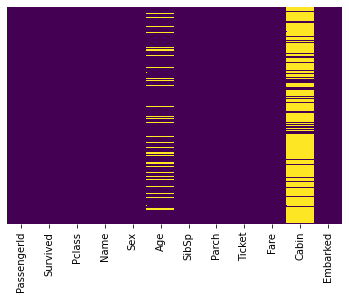

In [6]:
#missing data check
sns.heatmap(train.isnull(),yticklabels = False,cbar=False,cmap='viridis')
#some data point in Age category missing, plenty missing in Cabin

Exploratory Data Analysis

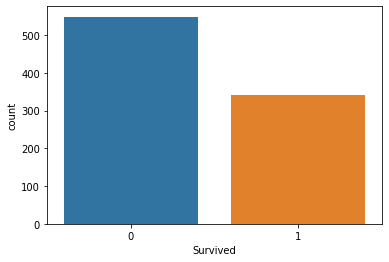

In [7]:
#Survivors distribution
sns.countplot(x='Survived', data=train);

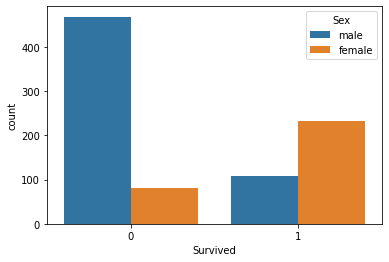

In [8]:
#Survivors by sex distribution
sns.countplot(x='Survived', hue='Sex', data=train);

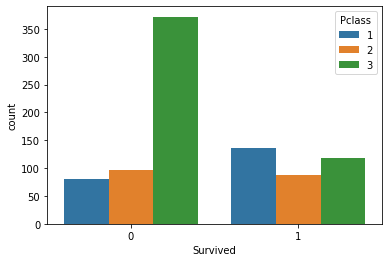

In [9]:
#Survivors by passanger class distribution
sns.countplot(x='Survived', hue='Pclass', data=train);

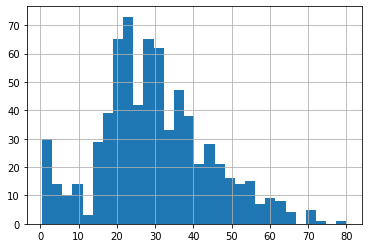

In [10]:
#Age distribution
train['Age'].dropna().hist(bins=30)
#a bimodal distribution is observed - one mode in the children group, the other - in the adults one.

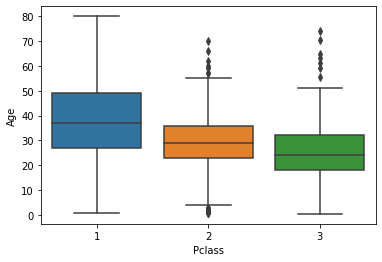

In [11]:
#Age distribution by passenger class
sns.boxplot(x='Pclass',y='Age',data=train)

Feature engineering

In [86]:
#function for extracting the honorific of a person
def honorific(col):
    hon = col.split(sep=', ')[1].split(sep='. ')[0]
    return hon

In [87]:
train['Honorific'] = train['Name'].apply(honorific)

In [88]:
#based on passenger class and honorific, I impute the mising values of Age
age_imp = train.groupby(['Pclass','Honorific']).mean()[['Age']].reset_index()
def impute_age(dpoint):
    Age = dpoint[0]
    Pclass = dpoint[1]
    Honorific = dpoint[2]
    if pd.isnull(Age):
        return age_imp[(age_imp['Pclass'] == dpoint[1])&(age_imp['Honorific'] == dpoint[2])]['Age'].values
    else:
        return Age

In [89]:
train['Age'] = train[['Age','Pclass','Honorific']].apply(impute_age,axis=1)

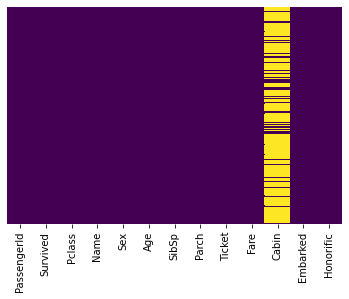

In [90]:
#checking the missing data again
sns.heatmap(train.isnull(),yticklabels = False,cbar=False,cmap='viridis');

In [91]:
#too many data points are missing for Cabin, so I drop the variable
train.drop('Cabin',axis=1,inplace=True)

In [92]:
#Categorical variables Sex, Embarked, Honorific need to be transformed via dummy variables
sex = pd.get_dummies(train['Sex'],drop_first = True)
embarked = pd.get_dummies(train['Embarked'],drop_first = True)
honorific = pd.get_dummies(train['Honorific'],drop_first = True)
train.drop(['Sex','Embarked','Honorific'], axis=1, inplace=True)
train = pd.concat([train,sex,embarked,honorific],axis=1)

In [93]:
train.head()

,PassengerId,Survived,Pclass,Name,Age,SibSp,Parch,Ticket,Fare,male,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,1,0,3,"Braund, Mr. Owen Harris",22,1,0,A/5 21171,7.2500,1,...,0,0,0,0,1,0,0,0,0,0
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",38,1,0,PC 17599,71.2833,0,...,0,0,0,0,0,1,0,0,0,0
2,3,1,3,"Heikkinen, Miss. Laina",26,0,0,STON/O2. 3101282,7.9250,0,...,0,1,0,0,0,0,0,0,0,0
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",35,1,0,113803,53.1000,0,...,0,0,0,0,0,1,0,0,0,0
4,5,0,3,"Allen, Mr. William Henry",35,0,0,373450,8.0500,1,...,0,0,0,0,1,0,0,0,0,0


In [94]:
#I drop PassengerId as it does not bring any meaningful information to the problem, as well as Name and Ticket number.
#From Name I extracted honorifics
train.drop(['PassengerId','Name','Ticket'], axis=1, inplace=True)

In [95]:
train.head()

,Survived,Pclass,Age,SibSp,Parch,Fare,male,Q,S,Col,...,Master,Miss,Mlle,Mme,Mr,Mrs,Ms,Rev,Sir,the Countess
0,0,3,22,1,0,7.2500,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0
1,1,1,38,1,0,71.2833,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,1,3,26,0,0,7.9250,0,0,1,0,...,0,1,0,0,0,0,0,0,0,0
3,1,1,35,1,0,53.1000,0,0,1,0,...,0,0,0,0,0,1,0,0,0,0
4,0,3,35,0,0,8.0500,1,0,1,0,...,0,0,0,0,1,0,0,0,0,0


Logistic Regression

In [96]:
#defining the features and the target
X = train.drop('Survived', axis=1)
y = train['Survived']

In [97]:
#splitting the data into the train and test sets
from sklearn.model_selection import train_test_split

In [98]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

In [99]:
from sklearn.linear_model import LogisticRegression

In [100]:
#fitting the model
mod = LogisticRegression()
mod.fit(X_train,y_train)

/home/dataguy/.local/lib/python3.6/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='warn', n_jobs=None, penalty='l2',
                   random_state=None, solver='warn', tol=0.0001, verbose=0,
                   warm_start=False)

In [101]:
predictions = mod.predict(X_test)

In [102]:
#importing helpful tools for model performance analysis
from sklearn.metrics import classification_report, confusion_matrix

In [103]:
print(classification_report(y_test, predictions))
print('\n')
print(confusion_matrix(y_test, predictions))

              precision    recall  f1-score   support

           0       0.82      0.91      0.86       149
           1       0.86      0.75      0.80       119

    accuracy                           0.84       268
   macro avg       0.84      0.83      0.83       268
weighted avg       0.84      0.84      0.83       268



[[135  14]
 [ 30  89]]
